## Serialization Test for LSTM Model

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from pathlib import Path
from netCDF4 import Dataset
import sys
sys.path.append("../src/")
# This is the BMI LSTM that we will be running
import bmi_lstm

# Additional imports
import pickle
import numpy as np

In [2]:
# This sample dataset comes from NeuralHydrology: 
# https://github.com/neuralhydrology/neuralhydrology/tree/master/test/test_data/camels_us/hourly
sample_data = Dataset('../data/usgs-streamflow-nldas_hourly.nc', 'r')

# Four basins are included in this sample
sample_basins = {sample_data['basin'][x]:x for x in range(len(list(sample_data['basin'])))}


### Create an instance of the LSTM model with BMI and initialize

In [3]:
model1 = bmi_lstm.bmi_LSTM()

# Initialize model with a configuration file
model1.initialize(bmi_cfg_file=Path('../bmi_config_files/01022500_hourly_slope_mean_precip_temp.yml'))

In [4]:
# The basin listed in the configuration has to be included in the sample basins for this example to run
# This is the location of the example basin in the sample data provided
# Note that this model can run on any basin, but this example includes observations from specific basins

ibasin = sample_basins[model1.cfg_bmi['basin_id']]


### Run model 1 with sample data for n1_steps

In [5]:
# Store the output in a list, so we can plot it afterwards
runoff_output_list1 = []

precip_list = list(sample_data['total_precipitation'][ibasin].data)
temp_list   = list(sample_data['temperature'][ibasin].data)
n_steps     = len(precip_list)

# Loop through the sample data
# for precip, temp in zip(list(sample_data['total_precipitation'][ibasin].data),
#                        list(sample_data['temperature'][ibasin].data)):

# Can change "5" here to anything less than n_steps
n1_steps = min(50, n_steps)

for k in range(n1_steps):
    # Set the model forcings to those in the sample data
    precip = precip_list[k]
    temp   = temp_list[k]
    model1.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux',np.atleast_1d(precip))
    model1.set_value('land_surface_air__temperature',np.atleast_1d(temp))

    # Updating the model calculates the runoff from the inputs and the model state at this time step
    model1.update()
        
    # Add the output to a list so we can plot
    runoff_output_list1.append(model1.surface_runoff_mm)

print('Ran LSTM model for', n1_steps, 'time steps.')

Ran LSTM model for 50 time steps.


### Serialize the first model with pickle as binary

In [6]:
pkl_file = './model1_state.pkl'
pkl_unit = open('./model1_state.pkl', 'wb')
pickle.dump( model1, pkl_unit )
pkl_unit.close()
print('Model 1 state serialized to binary file:', pkl_file)

Model 1 state serialized to binary file: ./model1_state.pkl


### Deserialize first model into model 2

In [7]:
pkl_unit = open('./model1_state.pkl', 'rb')
model2 = pickle.load( pkl_unit )
pkl_unit.close()
print('Model 2 state deserialized from binary file:', pkl_file)

runoff_output_list2 = runoff_output_list1.copy()  #### need copy()

Model 2 state deserialized from binary file: ./model1_state.pkl


### Run both models for another n2_steps

Note that model2.initialize() was not called, and model2.update() has not been called before now.  The entire model2 state was read from the pkl_file we created for model1.

In [8]:

for k in range(n1_steps, n_steps, 1):
    # Set the model forcings to those in the sample data
    precip = precip_list[k]
    temp   = temp_list[k]
    model1.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux',np.atleast_1d(precip))
    model1.set_value('land_surface_air__temperature',np.atleast_1d(temp))

    model2.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux',np.atleast_1d(precip))
    model2.set_value('land_surface_air__temperature',np.atleast_1d(temp))
    
    # Updating the model calculates the runoff from the inputs and the model state at this time step
    model1.update()
    model2.update()
        
    # Add the output to a list so we can plot
    runoff_output_list1.append(model1.surface_runoff_mm)
    runoff_output_list2.append(model2.surface_runoff_mm)

diff = (n_steps - n1_steps)
print('Ran both models for another', diff, 'time steps.')

Ran both models for another 26254 time steps.


### Compare outputs of the 2 model instances

In [9]:
output1 = np.array( runoff_output_list1 )
output2 = np.array( runoff_output_list2 )
w = (output1 != output2)   # boolean array
m = w.sum()
if (m == 0):
    print('Outputs for the two models are identical.')
else:
    print('Outputs for the two models differ at:')
    print('   ' + str(m) + 'locations.')

print()
print(output1[0:20])
print()
print(output2[0:20])

Outputs for the two models are identical.

[0.03823785 0.02977234 0.02930899 0.02575654 0.02411911 0.02225973
 0.02074922 0.01939082 0.01850858 0.01801368 0.01777347 0.01746739
 0.01757626 0.01721251 0.0165634  0.01631762 0.01561912 0.01560678
 0.01539082 0.01570429]

[0.03823785 0.02977234 0.02930899 0.02575654 0.02411911 0.02225973
 0.02074922 0.01939082 0.01850858 0.01801368 0.01777347 0.01746739
 0.01757626 0.01721251 0.0165634  0.01631762 0.01561912 0.01560678
 0.01539082 0.01570429]


### Finalize both model instances

In [10]:
model1.finalize()
model2.finalize()

### Plot a portion of the output for Model 1

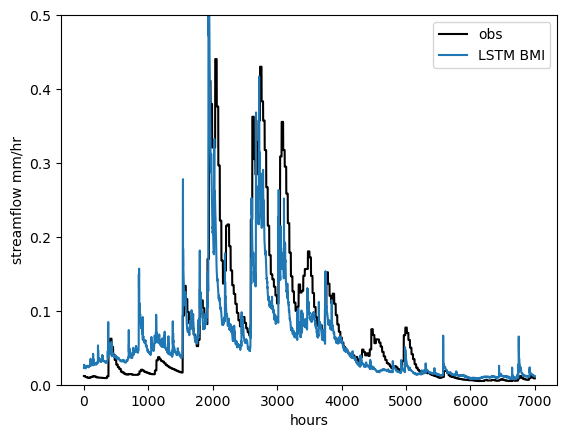

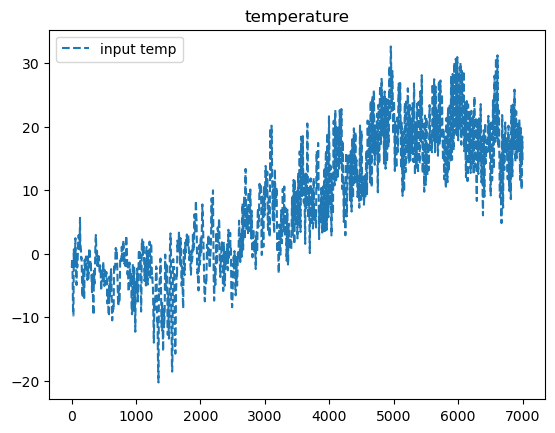

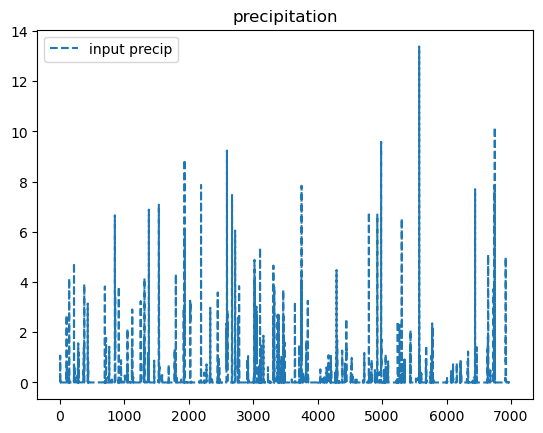

In [11]:
start_plot=17000
end_plot  =24000
plt.plot(sample_data['qobs_CAMELS_mm_per_hour'][ibasin][start_plot:end_plot], label='obs', c='k')
plt.plot(runoff_output_list1[start_plot:end_plot],label='LSTM BMI')
plt.ylim([0,0.5])
plt.ylabel('streamflow mm/hr')
plt.xlabel('hours')
plt.legend()
plt.show()
plt.close()
plt.plot(list(sample_data['temperature'][ibasin].data)[start_plot:end_plot], '--', label='input temp')
plt.title('temperature')
plt.legend()
plt.show()
plt.close()
plt.plot(list(sample_data['total_precipitation'][ibasin].data)[start_plot:end_plot], '--', label='input precip')
plt.title('precipitation')
plt.legend()
plt.show()
plt.close()

### Plot a portion of the output for Model 2

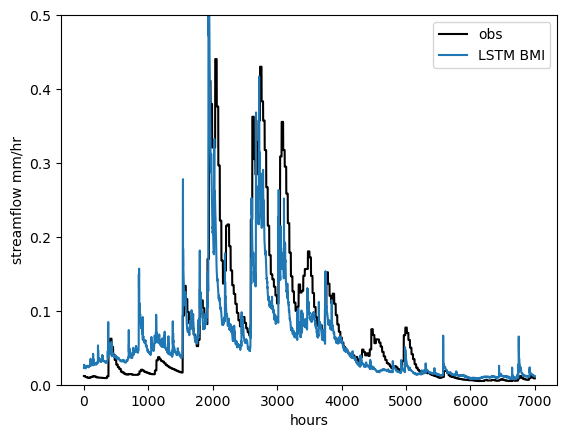

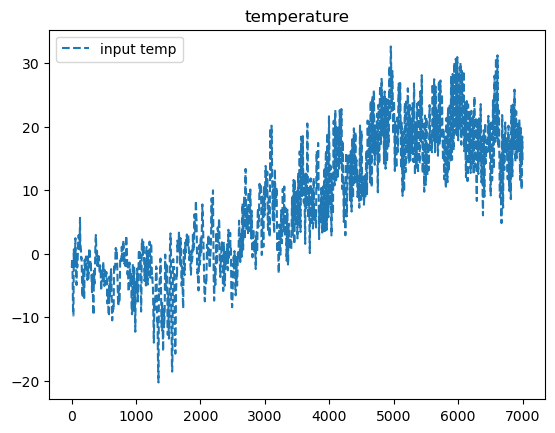

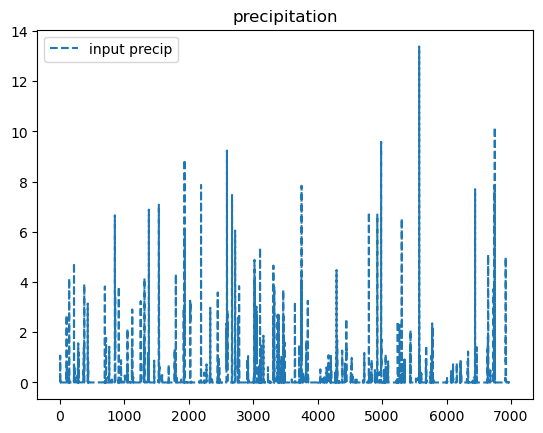

In [12]:
start_plot=17000
end_plot  =24000
plt.plot(sample_data['qobs_CAMELS_mm_per_hour'][ibasin][start_plot:end_plot], label='obs', c='k')
plt.plot(runoff_output_list2[start_plot:end_plot],label='LSTM BMI')
plt.ylim([0,0.5])
plt.ylabel('streamflow mm/hr')
plt.xlabel('hours')
plt.legend()
plt.show()
plt.close()
plt.plot(list(sample_data['temperature'][ibasin].data)[start_plot:end_plot], '--', label='input temp')
plt.title('temperature')
plt.legend()
plt.show()
plt.close()
plt.plot(list(sample_data['total_precipitation'][ibasin].data)[start_plot:end_plot], '--', label='input precip')
plt.title('precipitation')
plt.legend()
plt.show()
plt.close()